In [80]:
import pandas as pd
import os

In [81]:
df = pd.DataFrame()
filenames = []
directory = []
label = []
for filename in os.listdir('/kaggle/input/covidhackathon/data/class_a'):
    filenames.append('/kaggle/input/covidhackathon/data/class_a/'+filename)
    #directory.append('/kaggle/input/covidhackathon/data/class_a')
    label.append(1)
for filename in os.listdir('/kaggle/input/covidhackathon/data/class_b'):
    filenames.append('/kaggle/input/covidhackathon/data/class_b/'+filename)
    #directory.append('/kaggle/input/covidhackathon/data/class_b')
    label.append(0)
df['images'] = filenames
df['label']  = label

In [82]:
df = df.sample(frac=1).reset_index(drop=True)
df

,images,label
0,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
1,/kaggle/input/covidhackathon/data/class_a/7AF6...,1
2,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
3,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
4,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
...,...,...
416,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
417,/kaggle/input/covidhackathon/data/class_a/6C94...,1
418,/kaggle/input/covidhackathon/data/class_b/IM-0...,0
419,/kaggle/input/covidhackathon/data/class_b/IM-0...,0


In [83]:
df['label'].value_counts()

0    306
1    115
Name: label, dtype: int64

In [84]:
import cv2
h, w = 224, 224

train_images, train_labels = [], []

for i in range(len(df.images)):
  #print(df.images[i])
  train_image = cv2.imread(df.images[i])
  train_image = cv2.resize(train_image, (w, h)).astype('float32')
  train_images.append(train_image)
  train_labels.append(df.label[i])


In [85]:
import numpy as np
train_images = np.array(train_images)

In [86]:
len(train_labels)

421

In [87]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images, to_categorical(train_labels), test_size=0.1,random_state=25)

In [88]:
len(y_train)

378

In [89]:

from keras.applications.resnet50 import ResNet50
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D,AveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator


In [90]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [91]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [92]:
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [93]:
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback

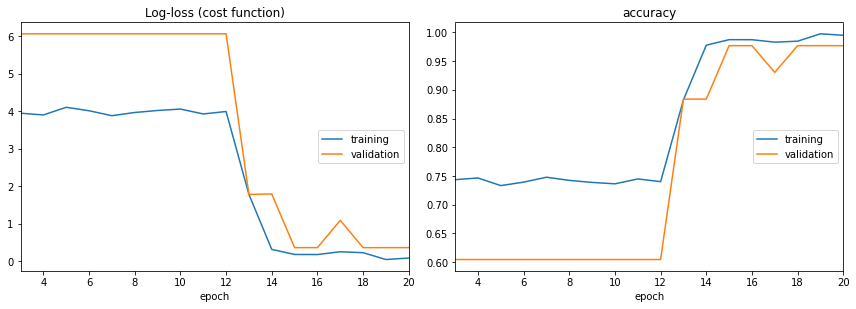

Log-loss (cost function):
training   (min:    0.040, max:    4.102, cur:    0.079)
validation (min:    0.357, max:    6.064, cur:    0.357)

accuracy:
training   (min:    0.733, max:    0.997, cur:    0.995)
validation (min:    0.605, max:    0.977, cur:    0.977)


In [94]:
batch_size =32
epochs = 20
model.fit_generator(trainAug.flow(X_train, y_train,batch_size), validation_data= (X_test, y_test),
                    steps_per_epoch=len(X_train)//10, epochs=epochs,validation_steps=len(X_test)//batch_size,callbacks=[PlotLossesCallback()])

In [95]:
model_json = model.to_json()
with open('covid_hackathon.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights("model_weights_res50.h5")

In [96]:
from keras.models import model_from_json

json_file = open('covid_hackathon.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_weights_res50.h5")

In [97]:
evaluation = model.evaluate(X_test, y_test)
evaluation

43/43 [==============================] - 0s 4ms/step


[0.35667658961096477, 0.9767441749572754]

In [99]:
y_pred=model.predict(X_test)


In [103]:
import sklearn.metrics as metrics
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[26,  0],
       [ 1, 16]])

In [106]:
from sklearn.metrics import classification_report 
a = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 

In [108]:
print(a)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.94      0.97        17

    accuracy                           0.98        43
   macro avg       0.98      0.97      0.98        43
weighted avg       0.98      0.98      0.98        43

